In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [2]:
from gensim import models

In [88]:
import random 
random.seed(99)

In [3]:
# Plotting tools
import pyLDAvis

In [5]:
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
#cleaning and filter the words
import datetime
import sys
import codecs
import re
import urllib, urllib2
import itertools, collections

import nltk  # Natural Language Processing
#nltk.download('punkt')
#nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords # list of words
from collections import Counter  # optimized way to do this
import string  # list(string.punctuation) - produces a list of punctuations
import copy
from itertools import product, tee, combinations, chain
from nltk.stem import PorterStemmer
from operator import itemgetter # help with dataframes

from scipy.spatial.distance import cosine

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

In [7]:
# Regex from Gagan ************************************************************

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

# Regex_str is used to GET text from CSV file

regex_str = [
    
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-signs
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)' # other words
]

# These Regex are used to EXCLUDE items from the text AFTER IMPORTING from csv with regex_str

numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
URL = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
html_tag = r'<[^>]+>'
hash_tag = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
at_sign = r'(?:@[\w_]+)'
dash_quote = r"(?:[a-z][a-z'\-_]+[a-z])"
other_word = r'(?:[\w_]+)'
other_stuff = r'(?:\S)' # anything else - NOT USED
start_pound = r"([#?])(\w+)" # Start with #
start_quest_pound = r"(?:^|\s)([#?])(\w+)" # Start with ? or with #
cont_number = r'(\w*\d\w*)' # Words containing numbers

# My REGEX **************************************************************************

#      Remove '[' and ']' brackets

sq_br_f = r'(?:[[\w_]+)' # removes '['
sq_br_b = r'(?:][\w_]+)' # removes ']'

rem_bracket = r'(' + '|'.join([sq_br_f, sq_br_b]) +')'
rem_bracketC = re.compile(rem_bracket, re.VERBOSE)

# Removes all words of 3 characters or less *****************************************************

short_words = r'\W*\b\w{1,3}\b' # Short words of 3 character or less
short_wordsC = re.compile(short_words, re.VERBOSE | re.IGNORECASE)

# REGEX remove all words with \ and / combinations

slash_back =  r'\s*(?:[\w_]*\\(?:[\w_]*\\)*[\w_]*)'
slash_fwd = r'\s*(?:[\w_]*/(?:[\w_]*/)*[\w_]*)'
slash_all = r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)'

# REGEX numbers, short words and URL only to EXCLUDE +++++++++++++++++++++++++++++++++++++++++++++++++++

num_url_short = r'(' + '|'.join([numbers, URL, short_words + sq_br_f + sq_br_b]) +')'  # Exclude from tweets
comp_num_url_short = re.compile(num_url_short, re.VERBOSE | re.IGNORECASE)

# Master REGEX to INCLUDE from the original tweets ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

list_regex = r'(' + '|'.join(regex_str) + ')'

master_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE) # TAKE from tweets INITIALLY

In [8]:
char_remove = [']', '[', '(', ')', '{', '}'] # characters to be removed

#the other 3character length words will be removed
words_keep = ['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio']

emotion_list = [':)', ';)', '(:', '(;', '}', '{','}']


word_garb = ['here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve']

extra_word_garb = []

#extra_word_garb = ['today','london','greater']

# Dictionary with Replacement Pairs ******************************************************************************
#repl_dict = {'googleele': 'goog', 'lyin': 'lie', 'googles': 'goog', 'aapl':'apple',\
#             'msft':'microsoft', 'google': 'goog', 'googl':'goog'}

repl_dict = {}

exclude = list(string.punctuation) + emotion_list + word_garb + extra_word_garb

# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

stemmer=PorterStemmer()
lmtzr = WordNetLemmatizer()

2. Prerequisites – Download nltk stopwords and spacy model
We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

##### Run in python console
import nltk; nltk.download('stopwords')

##### Run in terminal or command prompt
python3 -m spacy download en

## 5. Prepare Stopwords

We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [9]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## 6. Import Newsgroups Data

We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as newsgroups.json.

This is imported using pandas.read_json and the resulting dataset has 3 columns as shown.

In [47]:
filenames = ['london2017_q2_msoa.csv','london2017_q1_msoa.csv','london2016_q4_msoa.csv','london2016_q3_msoa.csv',
             'london2016_q2_msoa.csv','london2016_q1_msoa.csv','london2015_q4_msoa.csv','london2015_q3_msoa.csv']

#for filename in filenames[1:]:
#    clean_doc(filename)
    

In [55]:
filename = 'london2017_q2_msoa.csv'

In [56]:
# Import Dataset
directory = 'output/'+ filename
import sys

df = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                 error_bad_lines=False, parse_dates=True)
#df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#print(df.target_names.unique())
df.head()

,index_right,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,text
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,Think like a toddler- when we are at our most ...
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,Just posted a photo @ Moby Dick https://t.co/Z...
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,Working @ Chadwell Heath https://t.co/STy2bMBJ...
3,3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,#Shielding🛡🤓🎸 @ Dagenham United Kingdom ht...
4,4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,Kye's in the pub for the first time. Ordered h...


## 7. Remove hashtag, URL, and at_sign characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [57]:
# Filters IMPORTED from csv file data

def filterPick(list, filter):
    return [ ( l, m.group(1) ) for l in list for m in (filter(l),) if m]

search_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE).search

import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

# Convert to list
tweet_list_org = df.text.values.tolist()

tweet_list_org = [str(l).encode('ascii','ignore') for l in tweet_list_org]

outlist_init = filterPick(tweet_list_org, search_regex) # It is a tuple: initial list from all tweets

In [58]:
from time import time

In [59]:
def remove_shortwords(tw_clean_lst):
    return str([word for word in tw_clean_lst if len(word)>=3])

In [60]:
# Remove Emails
#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
#data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
#data = [re.sub("\'", "", sent) for sent in data]

#tw_clean_lst = [word for word in tw_clean_lst if word not in exclude]

outlist_init = filterPick(tweet_list_org, search_regex)

t0 = time()
outlist_init = [re.sub(URL, "", str(tw_clean)) for tw_clean in outlist_init]
print("URL done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(html_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("HTML_TAG done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(hash_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("hash_tag done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(slash_all,"", str(tw_clean)) for tw_clean in outlist_init]
print("slash_all done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(cont_number, "",str(tw_clean)) for tw_clean in outlist_init]
print("cont_number done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(numbers, "",str(tw_clean)) for tw_clean in outlist_init]
print("numbers done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(start_pound, "",str(tw_clean)) for tw_clean in outlist_init]

print("pound done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(start_quest_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("marks done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(at_sign, "",str(tw_clean)) for tw_clean in outlist_init]
print("at_sign done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub("'", "",str(tw_clean)) for tw_clean in outlist_init]
print("quotation done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub('"', "",str(tw_clean)) for tw_clean in outlist_init]
print("double quotation done in %0.3fs." % (time() - t0))
t0 = time()

# Removes # and @ in words (lookahead)
outlist_init = [re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', tw_clean) for tw_clean in outlist_init] 
print("symbols done in %0.3fs." % (time() - t0))

#data = [" ".join(i) for i in outlist_init]

pprint(outlist_init[:1])
data = outlist_init

URL done in 0.334s.
HTML_TAG done in 0.015s.
hash_tag done in 0.376s.
slash_all done in 2.466s.
cont_number done in 1.591s.
numbers done in 0.683s.
pound done in 0.259s.
marks done in 0.518s.
at_sign done in 0.040s.
quotation done in 0.021s.
double quotation done in 0.015s.
symbols done in 0.512s.
['(Think like a toddler- when we are at our most essential  vital  curious  joyful  playful   Was so happy to discover that my  design was being exhibited next to all the award  My  for   Was so happy to discover that my  design was being    ! Was so happy to discover that my  design was  Beautiful view        Students sample work at  Academy - today they used   to create on  SKY GARDEN           Gyalchester. Sushisamba Floor   THE SHARD    Great view of one of Londons most iconic buildings with image captured from another  Mind blowing views at Londons most exclusive observation decks and an open air terrace   Im at City Thameslink Railway Station (CTK) -  in Greater London  London    of you

After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

## 8. Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [61]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

In [63]:
data[1]

'(Just posted a photo Moby Dick  Limbo contest going off.....        Tantony Green  Limbo  wheelies and slow races all went off well today with  help. Great fun with kids  Foot  Fag  and Fone    Wardour Street  Im guest speaker for AdoptionUK this evening in Romford. Talking about Advocacy in Education tonight.  Wardour Street        What a bloody weekend  day  ibiza theme for WE ARE FEST    Premier Inn  Quick visits to the farm  ((Summer Open Day))      Dont often opt for the McFilth but when I do .... McDonalds  Did you see the final part of my Malaysia vlog series?    , Just)'

In [64]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[1])

[u'just', u'posted', u'photo', u'moby', u'dick', u'limbo', u'contest', u'going', u'off', u'tantony', u'green', u'limbo', u'wheelies', u'and', u'slow', u'races', u'all', u'went', u'off', u'well', u'today', u'with', u'help', u'great', u'fun', u'with', u'kids', u'foot', u'fag', u'and', u'fone', u'wardour', u'street', u'im', u'guest', u'speaker', u'for', u'adoptionuk', u'this', u'evening', u'in', u'romford', u'talking', u'about', u'advocacy', u'in', u'education', u'tonight', u'wardour', u'street', u'what', u'bloody', u'weekend', u'day', u'ibiza', u'theme', u'for', u'we', u'are', u'fest', u'premier', u'inn', u'quick', u'visits', u'to', u'the', u'farm', u'summer', u'open', u'day', u'dont', u'often', u'opt', u'for', u'the', u'mcfilth', u'but', u'when', u'do', u'mcdonalds', u'did', u'you', u'see', u'the', u'final', u'part', u'of', u'my', u'malaysia', u'vlog', u'series', u'just']


In [66]:
t0 = time()
data_words = [remove_shortwords(tw_clean) for tw_clean in data_words]
print("remove_shortwords done in %0.3fs." % (time() - t0))

print(data_words[1])

remove_shortwords done in 0.493s.
[u'just', u'posted', u'photo', u'moby', u'dick', u'limbo', u'contest', u'going', u'off', u'tantony', u'green', u'limbo', u'wheelies', u'and', u'slow', u'races', u'all', u'went', u'off', u'well', u'today', u'with', u'help', u'great', u'fun', u'with', u'kids', u'foot', u'fag', u'and', u'fone', u'wardour', u'street', u'guest', u'speaker', u'for', u'adoptionuk', u'this', u'evening', u'romford', u'talking', u'about', u'advocacy', u'education', u'tonight', u'wardour', u'street', u'what', u'bloody', u'weekend', u'day', u'ibiza', u'theme', u'for', u'are', u'fest', u'premier', u'inn', u'quick', u'visits', u'the', u'farm', u'summer', u'open', u'day', u'dont', u'often', u'opt', u'for', u'the', u'mcfilth', u'but', u'when', u'mcdonalds', u'did', u'you', u'see', u'the', u'final', u'part', u'malaysia', u'vlog', u'series', u'just']


## 9. Creating Bigram and Trigram Models (this is very important)
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [67]:
#Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[:1]]])

/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[u"[u'think', u'like', u'toddler', u'when', u'are', u'our', u'most', u'essential', u'vital', u'curious', u'joyful', u'playful', u'was', u'happy', u'discover', u'that', u'design', u'was', u'being', u'exhibited', u'next', u'all', u'the', u'award', u'for', u'was', u'happy', u'discover', u'that', u'design', u'was', u'being', u'was', u'happy', u'discover', u'that', u'design', u'was', u'beautiful', u'view', u'students', u'sample', u'work', u'academy', u'today', u'they', u'used', u'create', u'sky', u'garden', u'gyalchester', u'sushisamba', u'floor', u'the', u'shard', u'great', u'view', u'one', u'londons', u'most', u'iconic', u'buildings', u'with', u'image', u'captured', u'from', u'another', u'mind', u'blowing', u'views', u'londons', u'most', u'exclusive', u'observation', u'decks', u'and', u'open', u'air', u'terrace', u'city', u'thameslink', u'railway', u'station', u'ctk', u'greater', u'london', u'london', u'you', u'guys', u'are', u'clueless', u'eminem', u'train', u'coming', u'cct', u'venues',

## 10. Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [68]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [69]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [70]:
from __future__ import unicode_literals
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

In [71]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [72]:

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[u'think', u'toddler', u'essential', u'vital', u'curious', u'joyful', u'playful', u'happy', u'discover', u'design', u'exhibit', u'next', u'award', u'happy', u'discover', u'design', u'happy', u'discover', u'design', u'beautiful', u'view', u'student', u'sample', u'work', u'academy', u'today', u'use', u'create', u'sky', u'garden', u'gyalchester', u'sushisamba', u'floor', u'shard', u'great', u'view', u'london', u'iconic', u'building', u'image', u'capture', u'mind', u'blow', u'view', u'london', u'exclusive', u'observation', u'deck', u'open', u'air', u'terrace', u'city', u'thameslink', u'railway', u'station', u'ctk', u'great', u'london', u'london', u'guy', u'clueless', u'eminem', u'train', u'come', u'cct', u'venue', u'barbican', u'student', u'sample', u'work', u'academy', u'today', u'use', u'year', u'still', u'go', u'strong', u'kanaloa', u'club', u'station', u'impressive', u'spring', u'sky', u'royal', u'exchange', u'grand', u'caf', u'sauterelle', u'big', u'shout', u'cox', u'billingsgate', u

In [73]:
data_lemmatized_out = [" ".join(i) for i in data_lemmatized]
data_lemmatized_out = pd.DataFrame(data_lemmatized_out)
to_filename = 'cleaned_'+ filename
to_filename
data_lemmatized_out.to_csv(to_filename, encoding='utf-8' )

## 11. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [74]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 5), (2, 1), (3, 2), (4, 2), (5, 3), (6, 1), (7, 1), (8, 1), (9, 6), (10, 1), (11, 1), (12, 1), (13, 1), (14, 7), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 14), (24, 2), (25, 5), (26, 1), (27, 6), (28, 1), (29, 2), (30, 1), (31, 1), (32, 9), (33, 4), (34, 2), (35, 6), (36, 3), (37, 8), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 17), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 16), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 17), (74, 1), (75, 2), (76, 1), (77, 1), (78, 2), (79, 1), (80, 3), (81, 4), (82, 2), (83, 3), (84, 25), (85, 1), (86, 1), (87, 8), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 71), (97, 1), (98, 13), (99, 1), (100, 1), (101, 1), (102, 1), (103, 6), (104, 14), (105, 4), (106, 25), (107, 19), (108, 5), (109, 1)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [75]:
id2word[0]

u'inviterer'

In [76]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'inviterer', 1),
  (u'yellow', 5),
  (u'railing', 1),
  (u'gabriella', 2),
  (u'cyprus', 2),
  (u'otro', 3),
  (u'xtr', 1),
  (u'electricity', 1),
  (u'otra', 1),
  (u'lord', 6),
  (u'lora', 1),
  (u'mozarella', 1),
  (u'hormone', 1),
  (u'navigating', 1),
  (u'cipfa', 7),
  (u'bruschetta', 1),
  (u'deli', 2),
  (u'capoeira', 1),
  (u'hunni', 1),
  (u'fur', 1),
  (u'scholar', 1),
  (u'wooden', 1),
  (u'showcas', 2),
  (u'wednesday', 14),
  (u'tambin', 2),
  (u'solid', 5),
  (u'oooh', 1),
  (u'straight', 6),
  (u'fritter', 1),
  (u'charter', 2),
  (u'douard', 1),
  (u'jamjam', 1),
  (u'tired', 9),
  (u'miller', 4),
  (u'hanging', 2),
  (u'bacon', 6),
  (u'elegant', 3),
  (u'second', 8),
  (u'agethangelou', 1),
  (u'rehaut', 1),
  (u'admire', 2),
  (u'brexit', 1),
  (u'ruthless', 1),
  (u'cooking', 3),
  (u'lariojaaltasa', 1),
  (u'piala', 1),
  (u'fossil', 1),
  (u'hero', 1),
  (u'jani_london', 1),
  (u'nawo', 1),
  (u'hydrangea', 1),
  (u'here', 17),
  (u'leathercraft', 1),
  (u'lg

## 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [77]:
# Build LDA model
lda_model_20_100 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Build LDA model
lda_model_10_100 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 13. View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [78]:
# Print the Keyword in the 10 topics
pprint(lda_model_20_100.print_topics())
doc_lda = lda_model_20_100[corpus]

[(0,
  u'0.056*"wharf" + 0.048*"canary" + 0.030*"peckham" + 0.023*"peninsula" + 0.022*"india" + 0.016*"west" + 0.015*"walthamstow" + 0.013*"edgware" + 0.013*"east" + 0.010*"puregym"'),
 (1,
  u'0.049*"west" + 0.034*"apollo" + 0.032*"mile" + 0.026*"aladdin" + 0.025*"chiltern" + 0.025*"hammersmith" + 0.021*"finish" + 0.018*"cycling" + 0.015*"eal" + 0.010*"brentford"'),
 (2,
  u'0.074*"united" + 0.068*"kingdom" + 0.067*"wimbledon" + 0.024*"leyton" + 0.013*"surbiton" + 0.010*"mercato" + 0.008*"horniman" + 0.007*"humidity" + 0.006*"brisbane" + 0.005*"flickr"'),
 (3,
  u'0.200*"london" + 0.080*"great" + 0.013*"station" + 0.012*"hotel" + 0.009*"victoria" + 0.008*"square" + 0.007*"paddington" + 0.007*"railway" + 0.005*"amp" + 0.005*"garden"'),
 (4,
  u'0.058*"chiswick" + 0.035*"tate" + 0.033*"dock" + 0.021*"pimlico" + 0.017*"wapp" + 0.015*"hockney" + 0.009*"museum" + 0.008*"westbourne" + 0.007*"gipsy" + 0.007*"hawker"'),
 (5,
  u'0.118*"westminster" + 0.023*"ben" + 0.016*"limehouse" + 0.015*"h

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

## 14. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [82]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_20_100.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_20_100, \
                                     texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', -8.1659791493106191)
(u'\nCoherence Score: ', 0.55172285444463343)


In [75]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_10_100.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_10_100, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', -9.2814889907915301)
(u'\nCoherence Score: ', 0.55862864700861603)


## 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_20_100, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      38.746827        1       1  0.371846 -0.006503
13     17.171645        1       2  0.333612  0.005572
7      15.540476        1       3  0.307688 -0.001962
14      4.557583        1       4  0.219384  0.002921
11      3.853447        1       5  0.140776 -0.010025
0       3.442442        1       6  0.144533  0.010739
10      2.824904        1       7  0.054149  0.022374
12      2.698210        1       8 -0.002173  0.077647
19      1.463157        1       9 -0.099853 -0.400684
2       1.251273        1      10 -0.141279  0.032089
16      1.137316        1      11 -0.109135  0.031632
1       1.123521        1      12 -0.108953  0.004025
17      1.085040        1      13 -0.123559  0.021581
5       1.034448        1      14 -0.129331  0.034593
15      0.926012        1      15 -0.132942  0.026376
3       0.913504        1      16 -0.136737  0.035649
9       0.774927        1      17 -0.135579  0.029618
6       0.626829        1      18 -0.145596  0.030277
8       0.502074        1      19 -0.154466  0.029125
18      0.326367        1      20 -0.152385  0.024955, topic_info=      Category         Freq                 Term        Total  loglift  \
term                                                                     
7565   Default  1397.000000              station  1397.000000  30.0000   
51071  Default  1273.000000                 park  1273.000000  29.0000   
54818  Default  1512.000000                 soho  1512.000000  28.0000   
27227  Default   615.000000        covent_garden   615.000000  27.0000   
22736  Default  1472.000000               garden  1472.000000  26.0000   
68654  Default   462.000000                 mile   462.000000  25.0000   
53940  Default   781.000000            greenwich   781.000000  24.0000   
55880  Default  1109.000000                hotel  1109.000000  23.0000   
48895  Default  1174.000000               studio  1174.000000  22.0000   
50749  Default   581.000000                  eye   581.000000  21.0000   
10778  Default   604.000000      railway_station   604.000000  20.0000   
40031  Default   884.000000                 city   884.000000  19.0000   
1878   Default   374.000000     leicester_square   374.000000  18.0000   
8941   Default  2368.000000           last_night  2368.000000  17.0000   
68717  Default   837.000000       happy_birthday   837.000000  16.0000   
63299  Default   342.000000    buckingham_palace   342.000000  15.0000   
2581   Default   481.000000           marylebone   481.000000  14.0000   
76549  Default  1186.000000                 view  1186.000000  13.0000   
9247   Default  1182.000000                 home  1182.000000  12.0000   
19780  Default   318.000000           paddington   318.000000  11.0000   
5680   Default  2300.000000                night  2300.000000  10.0000   
33747  Default  1472.000000               street  1472.000000   9.0000   
28880  Default  4076.000000                  new  4076.000000   8.0000   
42424  Default   292.000000     trafalgar_square   292.000000   7.0000   
69481  Default  3576.000000         posted_photo  3576.000000   6.0000   
18982  Default   582.000000                 cake   582.000000   5.0000   
4078   Default  3033.000000              tonight  3033.000000   4.0000   
49497  Default   355.000000       united_kingdom   355.000000   3.0000   
20396  Default  4993.000000                 love  4993.000000   2.0000   
16441  Default   454.000000                tower   454.000000   1.0000   
...        ...          ...                  ...          ...      ...   
75816  Topic20    14.138394                turie    14.722428   5.6844   
33559  Topic20    13.400512  southwark_playhouse    13.984547   5.6822   
56535  Topic20    13.208689        delivery_para    13.792724   5.6816   
40898  Topic20    13.208689       meninas_compre    13.792724   5.6816   
75736  Topic20    13.208689    

In [76]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_10_100, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      57.485449        1       1  0.337507  0.006524
4      14.410044        1       2  0.287431 -0.036277
3      12.650831        1       3  0.271646 -0.028205
9       3.965216        1       4 -0.069416  0.324869
7       3.195310        1       5 -0.122046  0.119609
5       1.976284        1       6 -0.144399 -0.036161
0       1.886900        1       7 -0.117377 -0.116817
6       1.852569        1       8 -0.132670 -0.095849
8       1.526959        1       9 -0.156947 -0.067935
1       1.050437        1      10 -0.153729 -0.069757, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
54818  Default  1274.000000                soho  1274.000000  30.0000  30.0000
27227  Default   787.000000       covent_garden   787.000000  29.0000  29.0000
53940  Default   530.000000           greenwich   530.000000  28.0000  28.0000
51071  Default  1293.000000                park  1293.000000  27.0000  27.0000
7565   Default  1252.000000             station  1252.000000  26.0000  26.0000
40031  Default   856.000000                city   856.000000  25.0000  25.0000
55880  Default  1114.000000               hotel  1114.000000  24.0000  24.0000
69231  Default   849.000000             theatre   849.000000  23.0000  23.0000
33747  Default  1591.000000              street  1591.000000  22.0000  22.0000
28880  Default  4059.000000                 new  4059.000000  21.0000  21.0000
11303  Default  3604.000000                 get  3604.000000  20.0000  20.0000
2581   Default   475.000000          marylebone   475.000000  19.0000  19.0000
16441  Default   457.000000               tower   457.000000  18.0000  18.0000
1878   Default   443.000000    leicester_square   443.000000  17.0000  17.0000
4078   Default  3059.000000             tonight  3059.000000  16.0000  16.0000
12571  Default  1154.000000          restaurant  1154.000000  15.0000  15.0000
74215  Default  3138.000000                come  3138.000000  14.0000  14.0000
73744  Default  1104.000000            cocktail  1104.000000  13.0000  13.0000
67388  Default   400.000000         westminster   400.000000  12.0000  12.0000
47084  Default   303.000000        canary_wharf   303.000000  11.0000  11.0000
16680  Default   433.000000             mayfair   433.000000  10.0000  10.0000
11325  Default  1979.000000             morning  1979.000000   9.0000   9.0000
22736  Default  1407.000000              garden  1407.000000   8.0000   8.0000
62814  Default  3157.000000                work  3157.000000   7.0000   7.0000
24512  Default  3285.000000                make  3285.000000   6.0000   6.0000
10778  Default   558.000000     railway_station   558.000000   5.0000   5.0000
70216  Default  4755.000000                good  4755.000000   4.0000   4.0000
55960  Default   275.000000         marble_arch   275.000000   3.0000   3.0000
38784  Default   314.000000       oxford_circus   314.000000   2.0000   2.0000
60509  Default   353.000000           hyde_park   353.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
23772  Topic10    32.276577             whitton    32.827760   4.5390  -5.7385
62745  Topic10    31.436301          haus_silva    31.987498   4.5386  -5.7649
23798  Topic10    30.933053        burgess_park    31.485030   4.5383  -5.7810
51671  Topic10    28.247795    twickenham_stoop    28.798995   4.5366  -5.8718
54032  Topic10    27.482152          blackheath    28.033318   4.5361  -5.8993
37328  Topic10    26.233383  puregym_bermondsey    26.784622   4.5352  -5.9458
6423   Topic10    25.132047          roman_road    25.683522   4.5343  -5.9887
65646  Topic10    24.460738          white_post    25.011976   4.5337  -6.0158
7570   Topic10    22.622941         sager_wilde    23.178932   4.5317 

In [79]:


# Create Document - Topic Matrix
data_vectorized = tf_vectorizer.fit_transform(data_lemmatized)
lda_output = lda_model_10_100.transform(data_vectorized)

NameError: name 'tf_vectorizer' is not defined

In [78]:
# Create Document - Topic Matrix
data_vectorized = tf_vectorizer.fit_transform(data_lemmatized)
lda_output = lda_model_10_100.transform(data_vectorized)

# index names
docnames = ["Doc" + str(i) for i in range(len(data_lemmatized))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## 16. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

https://anoopacademia.wordpress.com/2015/01/18/install-mallet-on-windows-operating-system/

In [79]:
#import tempfile
#tempfile.tempdir='F:/'

import os 
os.environ.update({'MALLET_HOME':r'/Volumes/FREESPACE/workspace/temp'})


In [80]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/chenzhong/mallet-2.0.7/bin/mallet' # update this path

In [81]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [83]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [(u'great', 0.019608498),
   (u'stadium', 0.019441474),
   (u'london', 0.018572956),
   (u'wimbledon', 0.01823891),
   (u'borough', 0.017671032),
   (u'day', 0.017203366),
   (u'kingston', 0.016802512),
   (u'today', 0.012693747),
   (u'park', 0.010956707),
   (u'football', 0.01075628)]),
 (9,
  [(u'london', 0.03187963),
   (u'shoreditch', 0.021182556),
   (u'great', 0.016668625),
   (u'hackney', 0.014411661),
   (u'night', 0.014411661),
   (u'amp', 0.013518279),
   (u'day', 0.010367933),
   (u'hoxton', 0.0092394501),
   (u'tonight', 0.0081344778),
   (u'studio', 0.0076877866)]),
 (4,
  [(u'love', 0.015657997),
   (u'day', 0.013592822),
   (u'today', 0.01340614),
   (u'beautiful', 0.012046858),
   (u'make', 0.010600068),
   (u'happy', 0.0099466788),
   (u'morning', 0.0084882211),
   (u'lovely', 0.008342376),
   (u'week', 0.0081498595),
   (u'weekend', 0.0074497997)]),
 (3,
  [(u'amp', 0.04548642),
   (u'town', 0.018328445),
   (u'post', 0.011666454),
   (u'clapham', 0.011602703

## 17. How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [89]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [91]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, texts=data_lemmatized, 
                                                        start=1, limit=10, step=1)

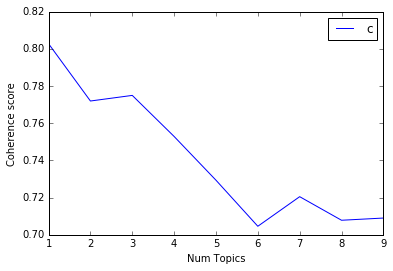

In [92]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [93]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

(u'Num Topics =', 1, u' has Coherence Value of', 0.8027)
(u'Num Topics =', 2, u' has Coherence Value of', 0.7719)
(u'Num Topics =', 3, u' has Coherence Value of', 0.7749)
(u'Num Topics =', 4, u' has Coherence Value of', 0.7529)
(u'Num Topics =', 5, u' has Coherence Value of', 0.7294)
(u'Num Topics =', 6, u' has Coherence Value of', 0.7046)
(u'Num Topics =', 7, u' has Coherence Value of', 0.7205)
(u'Num Topics =', 8, u' has Coherence Value of', 0.7078)
(u'Num Topics =', 9, u' has Coherence Value of', 0.709)


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [108]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  u'0.017*"today" + 0.012*"week" + 0.011*"session" + 0.010*"back" + 0.010*"work" + 0.010*"class" + 0.009*"start" + 0.009*"good" + 0.009*"morning" + 0.008*"drinking"'),
 (1,
  u'0.013*"battersea" + 0.012*"today" + 0.010*"club" + 0.009*"love" + 0.009*"holborn" + 0.009*"good" + 0.008*"show" + 0.008*"putney" + 0.008*"time" + 0.008*"covent_garden"'),
 (2,
  u'0.126*"london" + 0.055*"great" + 0.043*"soho" + 0.012*"street" + 0.012*"night" + 0.009*"love" + 0.009*"club" + 0.008*"time" + 0.008*"good" + 0.007*"theatre"'),
 (3,
  u'0.023*"east" + 0.020*"stratford" + 0.013*"canary_wharf" + 0.011*"posted_photo" + 0.010*"city" + 0.009*"great" + 0.008*"good" + 0.008*"islington" + 0.008*"time" + 0.008*"love"'),
 (4,
  u'0.018*"night" + 0.017*"covent_garden" + 0.012*"great" + 0.011*"theatre" + 0.010*"leicester_square" + 0.009*"good" + 0.009*"birthday" + 0.009*"love" + 0.008*"happy" + 0.008*"posted_photo"'),
 (5,
  u'0.017*"game" + 0.012*"twickenham" + 0.011*"today" + 0.011*"time" + 0.011*"stadium" 

## 18. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [109]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

NameError: name 'lda_model' is not defined

## 19. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.



## 20. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

## 21. Conclusion

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.